In [2]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Gwen implementation 

In [2]:
def prob3():
    '''
    Solve the free time horizon BVP.
    Plot the solution and return the correct end time
    '''
    
    Pu = 9
    Pl = 7
    sigma = .1**2
    sy = 1

    tf = 3
    t0 = 0 


    #define ode 
    def ode(t,y):
        ''' define the ode system '''
        K = 1
        #x, y, x', y', p1, p2, p3, p4 

        #return np.array([(y[0] + .1*y[2]), (y[1] + .1*y[3]),y[3],-9.8 + y[4] + y[7], y[0]*0, y[0]*0, y[0]*0, -y[5]])
        #return np.array([y[2], y[3], 0*y[0], -9.8 + y[7], 0*y[0], 0*y[0], -y[4], -y[5]])
        return np.array([y[1], -9.8 + y[3], 0*y[0], y[2]])
    
    def bc(ya,yb):
        ''' define the boundary conditions '''
        '''return np.array([ya[0] - sx, ya[1] - sy, ya[2] - C, ya[3], 
                         yb[0] - 1,yb[2] - C, yb[5] + 1/sigma*np.exp(-((yb[1] - (Pu + Pl)/2)**2)/sigma)*2*(yb[1] - (Pu + Pl)/2), yb[7] - 0])'''
        return np.array([ya[0] - sy, ya[1] - 0, yb[2] + 1/sigma*np.exp(-((yb[0] - (Pu + Pl)/2)**2)/sigma)*2*(yb[0] - (Pu + Pl)/2), yb[3] - 0])
    
    # give the time domain
    t_steps = 100 
    t = np.linspace(0,3,t_steps)

    # give an initial guess
    y_guess = np.linspace(sy, (Pu+Pl)/2, t_steps)
    yp_guess = np.ones(t_steps)*(((Pu+Pl)/2 - sy) / (tf - t0))
    p0_guess = np.zeros(t_steps)
    p1_guess = np.ones(t_steps)
    y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

    # solve the system
    sol = solve_bvp(ode, bc, t, y0)

    print(sol)



    #plot
    plt.plot(sol.x, sol.y[0])
    plt.xlabel("t")
    plt.ylabel("y(t)")
    plt.title("Problem 3")
    plt.show()

    return   

       message: The algorithm converged to the desired accuracy.
       success: True
        status: 0
             x: [ 0.000e+00  3.030e-02 ...  2.970e+00  3.000e+00]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x14614f420>
             p: None
             y: [[ 1.000e+00  1.003e+00 ...  8.143e+00  8.031e+00]
                 [-5.354e-21  2.169e-01 ... -3.540e+00 -3.834e+00]
                 [-5.681e+00 -5.681e+00 ... -5.681e+00 -5.681e+00]
                 [ 1.704e+01  1.687e+01 ...  1.722e-01  0.000e+00]]
            yp: [[-5.354e-21  2.169e-01 ... -3.540e+00 -3.834e+00]
                 [ 7.244e+00  7.072e+00 ... -9.628e+00 -9.800e+00]
                 [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
                 [-5.681e+00 -5.681e+00 ... -5.681e+00 -5.681e+00]]
 rms_residuals: [ 1.653e-14  2.875e-15 ...  2.767e-15  8.793e-15]
         niter: 1


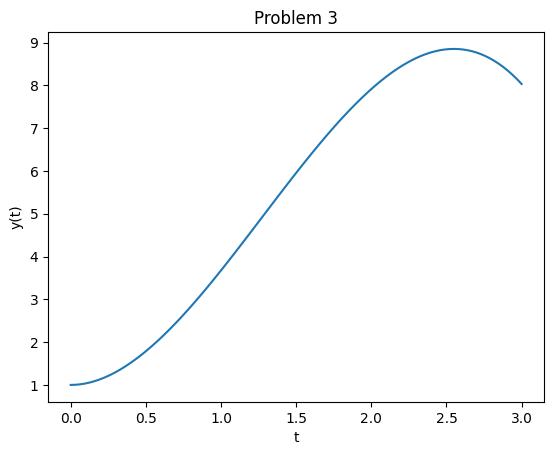

In [3]:
prob3()

## Obstacle avoidance 

In [3]:
def obstacle(x,y,W1=1,r=(1,1),c=(0,0)):
    '''
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40* W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

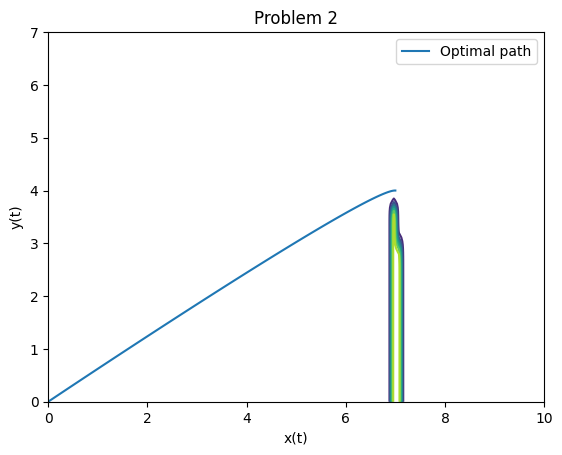

In [4]:
def prob2():
    '''
    Find the optimal path for the fixed time horizon problem
    '''
    #define Ws 
    W1 = 20
    W2 = .1

    #define X and Y 
    X = np.linspace(0,7,100)
    Y = np.linspace(0,2,100)
    
    #define y0 
    y0 = 1*np.ones((8, X.size))


    #define functions
    def fun(t, z):
        return np.vstack((z[2],z[3], 1/(2*W2)*z[6], 1/(2*W2)*z[7],obstacle_dx(z[0],z[1],W1=W1,r=(.01,8,),c=(7,1)),obstacle_dy(z[0],z[1],W1=W1,r=(.01,8,),c=(7,1)), -z[4], -z[5]))
    
    def bc(ya, yb):
        return np.array([ya[0], ya[1], ya[2], ya[3], yb[0] - 7, yb[1] - 4, yb[2], yb[3]])
    
    #solve and get x and y 
    res_a = solve_bvp(fun, bc, X, y0, max_nodes = 30000)

    x1 = res_a.y[0]
    y2 = res_a.y[1]

    #find obstacle 
    X = np.linspace(0,10,100)
    Y = np.linspace(0,7,100)
    x_,y_ = np.meshgrid(X,Y)
    obs = obstacle(x_,y_,W1=W1,r=(.01,8),c=(7,1))

    #plot
    plt.contour(x_, y_, obs)
    plt.plot(x1,y2, label = "Optimal path")
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.ylim(0,7)
    plt.title("Problem 2")
    plt.legend()
    plt.show()

prob2()

(8, 100)


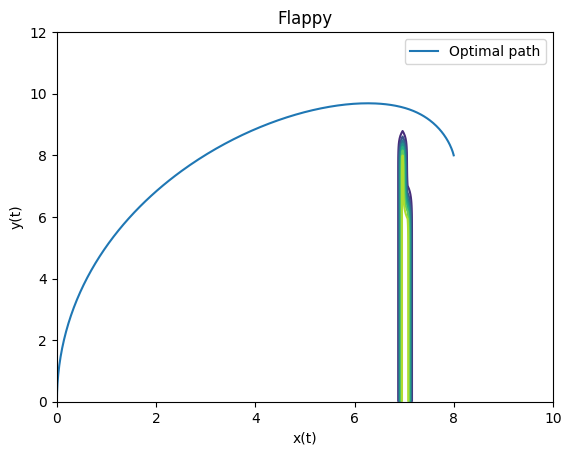

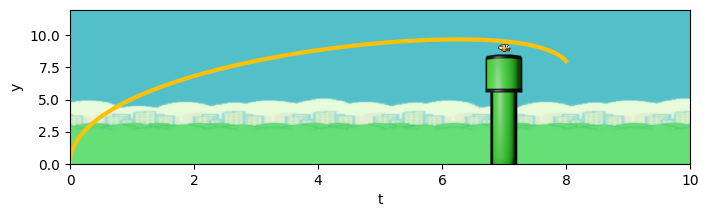

In [36]:
def pipe_avoid(W1 = 20, W2 = .1, rx = .01, ry = 60, center = (7,1), start_location = [0,0], end_location = [7,9]):


    #define X and Y 
    X = np.linspace(start_location[0],end_location[0] + 3,100)
    Y = np.linspace(start_location[1],end_location[1],100)

    #define y0 
    y0 = 1*np.zeros((8, X.size))

    #TEST
    start_y = start_location[1]
    t_steps = 100
    alpha = 2
    t0 = 0
    tf = 60
    x_guess = np.zeros(t_steps)
    xp_guess = np.zeros(t_steps)
    p2_guess = np.zeros(t_steps)
    p3_guess = np.zeros(t_steps)
    y_guess = np.linspace(start_y, (end_location[0])/2, t_steps)
    yp_guess = np.ones(t_steps)*(((end_location[0])/2 - start_y) / (tf - t0))
    p0_guess = np.zeros(t_steps)
    p1_guess = np.sin(alpha*np.linspace(t0, tf, t_steps))
    y0 = np.vstack((x_guess,y_guess, xp_guess, yp_guess, p0_guess, p1_guess, p2_guess, p3_guess))
    print(y0.shape)


    #define functions
    def fun(t, z):
        return np.vstack((z[2],z[3], 1/(2*W2)*z[6], 1/(2*W2)*z[7],obstacle_dx(z[0],z[1],W1=W1,r=(rx,ry,),c=center),obstacle_dy(z[0],z[1],W1=W1,r=(rx,ry,),c=center), -z[4], -z[5]))
    
    def bc(ya, yb):
        return np.array([ya[0]- start_location[0], ya[1] - start_location[1], ya[2], ya[3] - 3, yb[0] - (end_location[0] + 1), yb[1] - (end_location[1] - 1), yb[2], yb[3]])
    
    #TEST
    def bc2(ya, yb, p):
        u1 = 1/(2*W2)*yb[6]
        u2 = 1/(2*W2)*yb[7]
        return np.array([ya[0] - 6, ya[1] - 1.5, ya[2], ya[3], yb[0], yb[1], yb[2], yb[3], yb[4]*yb[2] + yb[5]*yb[3] + yb[6]*u1 + yb[7]*u2 - (1 + obstacle(yb[0],yb[1], W1=W1,r=(1,1),c=(0,0)) + W2*(u1**2 + u2**2))])
    
    #solve and get x and y 
    res_a = solve_bvp(fun, bc, X, y0)

    x1 = res_a.y[0]
    y2 = res_a.y[1]

    #find obstacle 
    X = np.linspace(start_location[0],end_location[0] + 3,100)
    Y = np.linspace(0,end_location[1],100)
    x_,y_ = np.meshgrid(X,Y)
    obs = obstacle(x_,y_,W1=W1,r=(rx,ry),c=center)

    #plot
    plt.contour(x_, y_, obs)
    plt.plot(x1,y2, label = "Optimal path")
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.xlim(start_location[0], end_location[0] + 3)
    plt.ylim(0,end_location[1] + 3)
    plt.title("Flappy")
    plt.legend()
    plt.show()

    # plot the x(t)
    plt.gcf().set_size_inches(8,2)

    plt.plot(x1, y2, linewidth=3, color="#ffc107")
    plt.xlabel("t")
    plt.ylabel("y")

    xlims = (start_location[0], end_location[0] + 3)
    ylims = (0,end_location[1] + 3)
    # plot the background
    background = mpimg.imread('images/extra/flappy_background.png')
    plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)


    xmin, xmax = end_location[0] - .3, end_location[0] + .3
    ymin, ymax = 0, end_location[1] - .5
    img = mpimg.imread('images/extra/pipe_cropped_lower.png')
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

    # plot the bird
    xmin, xmax = end_location[0] -.1 , end_location[0] + .1
    ymin, ymax = end_location[1] - .3, end_location[1] + .3
    bird = mpimg.imread('images/extra/bird_cropped.png')
    plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)

    plt.xlim(start_location[0], end_location[0] + 3)
    plt.ylim(0,end_location[1] + 3)
    plt.show()

pipe_avoid()

(8, 100)


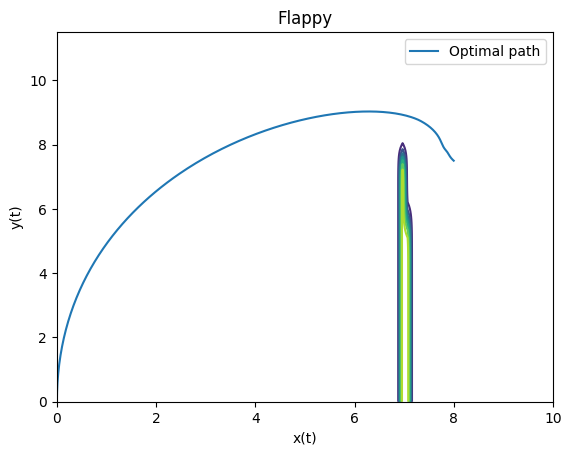

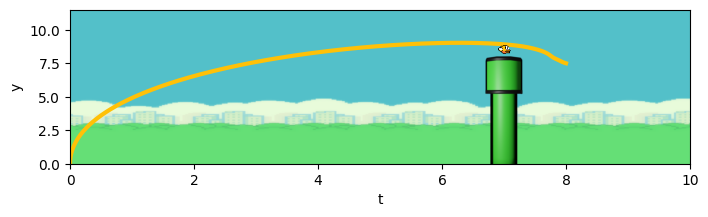

(8, 100)


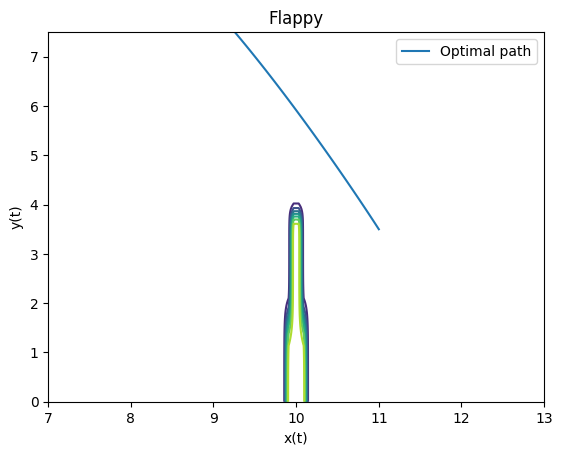

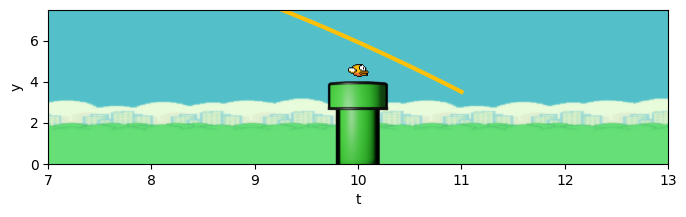

(8, 100)


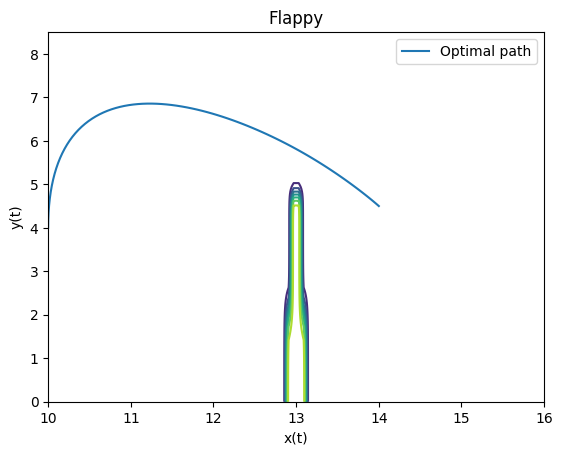

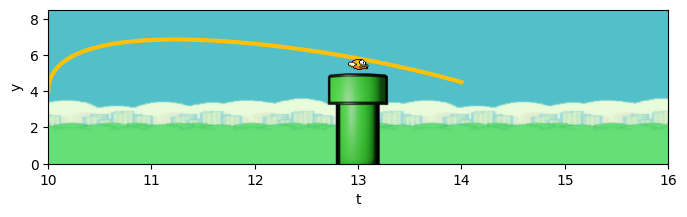

(8, 100)


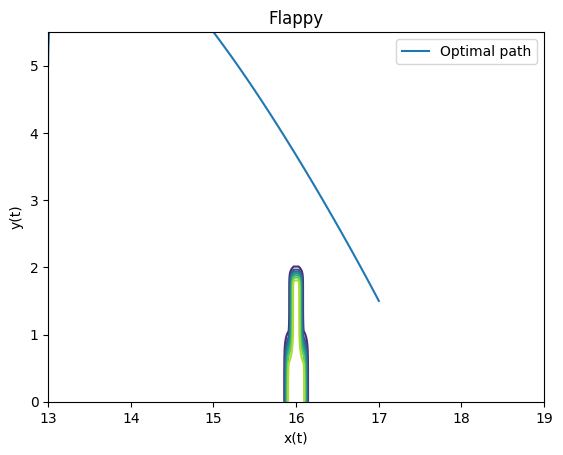

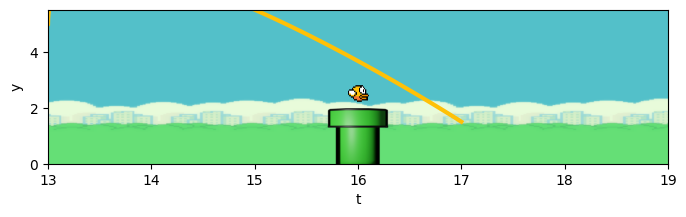

In [37]:
xs = [7, 10, 13, 16]
ys = [8, 4, 5, 2]
#ry = [8, 3, 6, 5]

start_loc_x = [0, 7, 10, 13]
start_loc_y = [0, 8, 4, 5]

for i in range(4):

    pipe_avoid(W1 = 20, W2 = .1, rx = .01, ry = ys[i]**2, center = (xs[i],0), start_location = [start_loc_x[i],start_loc_y[i]], end_location = [xs[i],ys[i]+.5])

## Add upper pipes

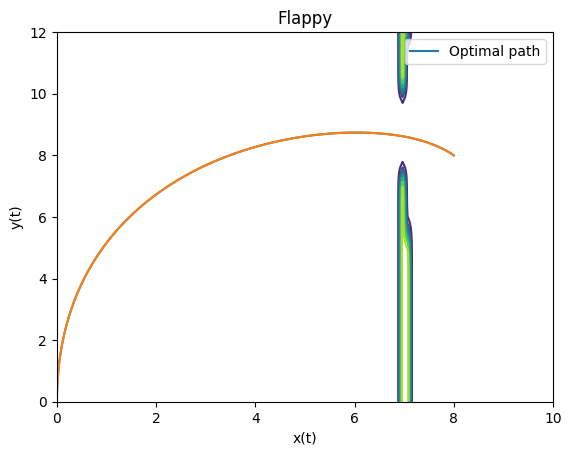

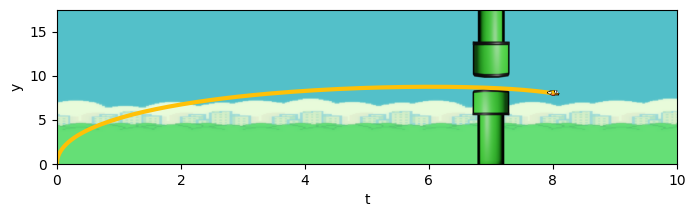

In [90]:
def pipe_avoid_uplow(W1 = 20, W2 = .1, rx = .01, ry = 60, center1 = (7,0), start_location = [0,0], end_location = [7,9]):

    center2 = (center1[0], 2*np.sqrt(ry) + 2)
    

    #define X and Y 
    X = np.linspace(start_location[0],end_location[0] + 3,100)
    Y = np.linspace(start_location[1],2 + np.sqrt(ry)*2,100)

    #define y0 
    y0 = 1*np.zeros((8, X.size))

    #TEST
    '''start_y = start_location[1]
    t_steps = 100
    alpha = 2
    t0 = 0
    tf = 60
    x_guess = np.zeros(t_steps)
    xp_guess = np.zeros(t_steps)
    p2_guess = np.zeros(t_steps)
    p3_guess = np.zeros(t_steps)
    y_guess = np.linspace(start_y, (end_location[0])/2, t_steps)
    yp_guess = np.ones(t_steps)*(((end_location[0])/2 - start_y) / (tf - t0))
    p0_guess = np.zeros(t_steps)
    p1_guess = np.sin(alpha*np.linspace(t0, tf, t_steps))
    y0 = np.vstack((x_guess,y_guess, xp_guess, yp_guess, p0_guess, p1_guess, p2_guess, p3_guess))'''


    #define functions
    def fun(t, z):
        return np.vstack((z[2],
                          z[3], 
                          1/(2*W2)*z[6], 
                          1/(2*W2)*z[7],
                          obstacle_dx(z[0],z[1],W1=W1,r=(rx,ry,),c=center1) + obstacle_dx(z[0],z[1],W1=W1,r=(rx,ry,),c=center2),
                          obstacle_dy(z[0],z[1],W1=W1,r=(rx,ry,),c=center1) + obstacle_dy(z[0],z[1],W1=W1,r=(rx,ry,),c=center2), 
                          -z[4],
                          -z[5]))
    
    def bc(ya, yb):
        return np.array([ya[0]- start_location[0], ya[1] - start_location[1], ya[2], ya[3] - 3, yb[0] - (end_location[0] + 1), yb[1] - (end_location[1] - 1), yb[2], yb[3]])
    
    
    #solve and get x and y 
    res_a = solve_bvp(fun, bc, X, y0)

    x1 = res_a.y[0]
    y2 = res_a.y[1]


    #find obstacle 
    X = np.linspace(start_location[0],end_location[0] + 3,100)
    Y = np.linspace(0,2 + np.sqrt(ry)*2,100)
    x_,y_ = np.meshgrid(X,Y)
    obs1 = obstacle(x_,y_,W1=W1,r=(rx,ry),c=center1)
    obs2 = obstacle(x_,y_,W1=W1,r=(rx,ry),c=center2)

    #plot
    plt.contour(x_, y_, obs1)
    plt.plot(x1,y2, label = "Optimal path")
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.xlim(start_location[0], end_location[0] + 3)
    plt.ylim(0,end_location[1] + 3)
    plt.title("Flappy")
    plt.legend()

    plt.contour(x_, y_, obs2)
    plt.plot(x1,y2)
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.xlim(start_location[0], end_location[0] + 3)
    plt.ylim(0,end_location[1] + 3)
    plt.title("Flappy")
    plt.legend()
    plt.show()

    # plot the x(t)
    plt.gcf().set_size_inches(8,2)

    plt.plot(x1, y2, linewidth=3, color="#ffc107")
    plt.xlabel("t")
    plt.ylabel("y")

    xlims = (start_location[0], end_location[0] + 3)
    ylims = (0,np.max([2 + np.sqrt(ry)*2, end_location[1]+3]))
    # plot the background
    background = mpimg.imread('images/extra/flappy_background.png')
    plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

    #plot lower pipe 
    xmin, xmax = end_location[0] - .3, end_location[0] + .3
    ymin, ymax = 0, end_location[1] - .5
    img = mpimg.imread('images/extra/pipe_cropped_lower.png')
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

    #plot upper pipe
    xmin, xmax = end_location[0] - .3, end_location[0] + .3
    ymin, ymax = center2[1] - np.sqrt(ry), center2[1] + 4
    img = mpimg.imread('images/extra/pipe_cropped_upper.png')
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')


    # plot the bird
    xmin, xmax = end_location[0] -.1 + 1, end_location[0] + .1 + 1
    ymin, ymax = end_location[1] - .3 - 1, end_location[1] + .3 - 1
    bird = mpimg.imread('images/extra/bird_cropped.png')
    plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)

    plt.xlim(start_location[0], end_location[0] + 3)
    plt.ylim(0, 2 + np.sqrt(ry)*2)
    plt.show()

pipe_avoid_uplow()

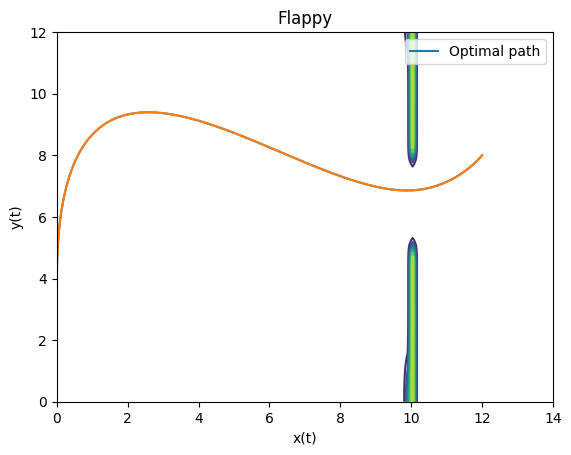

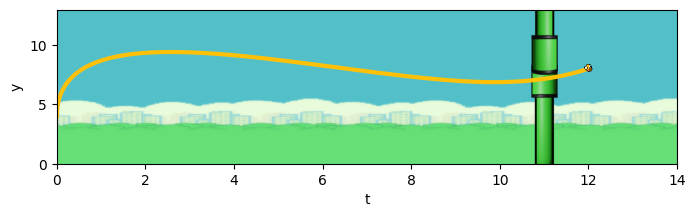

In [96]:
pipe_avoid_uplow(W1 = 20, W2 = .1, rx = .01, ry = 30, center1 = (10,0), start_location = [0,4], end_location = [11,9])

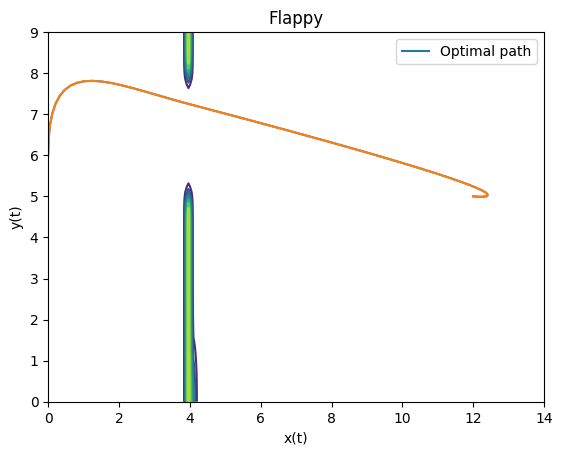

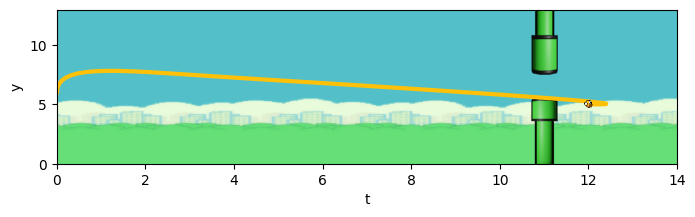

In [108]:
pipe_avoid_uplow(W1 = 20, W2 = .1, rx = .01, ry = 30, center1 = (4,0), start_location = [0,6], end_location = [11,6])

## Reward as middle circle 

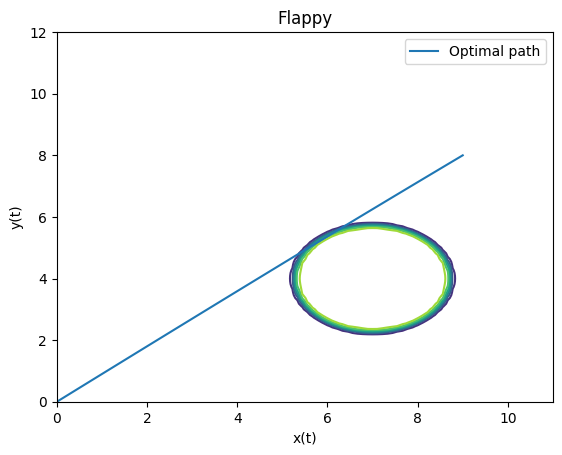

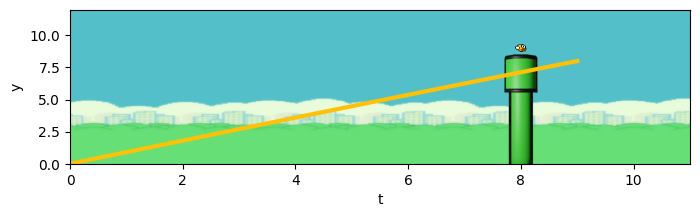

In [172]:
def pipe_reward(W1 = .01, W2 = 5, rx = 3, ry = 3, center = (7,4), start_location = [0,0], end_location = [8,9]):


    #define X and Y 
    X = np.linspace(start_location[0],end_location[0] + 3,100)
    Y = np.linspace(start_location[1],end_location[1],100)

    #define y0 
    y0 = 1*np.zeros((8, X.size))


    #define functions
    def fun(t, z):
        return np.vstack((-z[2],-z[3], -1/(2*W2)*z[6], -1/(2*W2)*z[7],-obstacle_dx(z[0],z[1],W1=W1,r=(rx,ry,),c=center), -obstacle_dy(z[0],z[1],W1=W1,r=(rx,ry,),c=center), z[4], z[5]))
    
    def bc(ya, yb):
        return np.array([ya[0]- start_location[0], ya[1] - start_location[1], ya[2], ya[3], yb[0] - (end_location[0] + 1), yb[1] - (end_location[1] - 1), yb[2], yb[3]])
    
    
    #solve and get x and y 
    res_a = solve_bvp(fun, bc, X, y0)

    x1 = res_a.y[0]
    y2 = res_a.y[1]

    #find obstacle 
    X = np.linspace(start_location[0],end_location[0] + 3,100)
    Y = np.linspace(0,end_location[1],100)
    x_,y_ = np.meshgrid(X,Y)
    obs = obstacle(x_,y_,W1=W1,r=(rx,ry),c=center)

    #plot
    plt.contour(x_, y_, obs)
    plt.plot(x1,y2, label = "Optimal path")
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.xlim(start_location[0], end_location[0] + 3)
    plt.ylim(0,end_location[1] + 3)
    plt.title("Flappy")
    plt.legend()
    plt.show()

    # plot the x(t)
    plt.gcf().set_size_inches(8,2)

    plt.plot(x1, y2, linewidth=3, color="#ffc107")
    plt.xlabel("t")
    plt.ylabel("y")

    xlims = (start_location[0], end_location[0] + 3)
    ylims = (0,end_location[1] + 3)
    # plot the background
    background = mpimg.imread('images/extra/flappy_background.png')
    plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)


    xmin, xmax = end_location[0] - .3, end_location[0] + .3
    ymin, ymax = 0, end_location[1] - .5
    img = mpimg.imread('images/extra/pipe_cropped_lower.png')
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

    # plot the bird
    xmin, xmax = end_location[0] -.1 , end_location[0] + .1
    ymin, ymax = end_location[1] - .3, end_location[1] + .3
    bird = mpimg.imread('images/extra/bird_cropped.png')
    plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)

    plt.xlim(start_location[0], end_location[0] + 3)
    plt.ylim(0,end_location[1] + 3)
    plt.show()

pipe_reward()

## Add multiple pipes with obstacle avoid

In [65]:
def pipe_avoid_multiple(rys, W1 = 20, W2 = .1, rx = .01, center1 = (7,0), start_location = [0,0], end_location = [7,9]):

    plt.xlim(0 , center1[0] + 3*len(rys))
    plt.ylim(0,np.sqrt(np.max(rys)) + 2) 

    for i in range(len(rys)):

        ry = rys[i]

        center1 = (center1[0]+ i*3, 0)

        center2 = (center1[0], 2*np.sqrt(rys[i]) + 2)
        

        #define X and Y 
        X = np.linspace(start_location[0],end_location[0] + 3,100)
        Y = np.linspace(start_location[1],2 + np.sqrt(ry)*2,100)

        #define y0 
        y0 = 1*np.zeros((8, X.size))

        #TEST
        '''start_y = start_location[1]
        t_steps = 100
        alpha = 2
        t0 = 0
        tf = 60
        x_guess = np.zeros(t_steps)
        xp_guess = np.zeros(t_steps)
        p2_guess = np.zeros(t_steps)
        p3_guess = np.zeros(t_steps)
        y_guess = np.linspace(start_y, (end_location[0])/2, t_steps)
        yp_guess = np.ones(t_steps)*(((end_location[0])/2 - start_y) / (tf - t0))
        p0_guess = np.zeros(t_steps)
        p1_guess = np.sin(alpha*np.linspace(t0, tf, t_steps))
        y0 = np.vstack((x_guess,y_guess, xp_guess, yp_guess, p0_guess, p1_guess, p2_guess, p3_guess))'''


        #define functions
        def fun(t, z):
            return np.vstack((z[2],
                            z[3], 
                            1/(2*W2)*z[6], 
                            1/(2*W2)*z[7],
                            obstacle_dx(z[0],z[1],W1=W1,r=(rx,ry,),c=center1) + obstacle_dx(z[0],z[1],W1=W1,r=(rx,ry,),c=center2),
                            obstacle_dy(z[0],z[1],W1=W1,r=(rx,ry,),c=center1) + obstacle_dy(z[0],z[1],W1=W1,r=(rx,ry,),c=center2), 
                            -z[4],
                            -z[5]))
        
        def bc(ya, yb):
            return np.array([ya[0]- start_location[0], ya[1] - start_location[1], ya[2], ya[3] - 3, yb[0] - (end_location[0] + 1), yb[1] - (end_location[1] - 1), yb[2], yb[3]])
        
        
        #solve and get x and y 
        res_a = solve_bvp(fun, bc, X, y0)

        x1 = res_a.y[0]
        y2 = res_a.y[1]

        #find obstacle 
        X = np.linspace(start_location[0],end_location[0] + 3,100)
        Y = np.linspace(0,2 + np.sqrt(ry)*2,100)
        x_,y_ = np.meshgrid(X,Y)
        obs1 = obstacle(x_,y_,W1=W1,r=(rx,ry),c=center1)
        obs2 = obstacle(x_,y_,W1=W1,r=(rx,ry),c=center2)

        #plot
        plt.contour(x_, y_, obs1)
        plt.plot(x1,y2, label = "Optimal path")
        plt.xlabel("x(t)")
        plt.ylabel("y(t)")
        plt.xlim(start_location[0], end_location[0] + 3)
        plt.ylim(0,end_location[1] + 3)
        plt.title("Flappy")
        plt.legend()

        plt.contour(x_, y_, obs2)
        plt.plot(x1,y2)
        plt.xlabel("x(t)")
        plt.ylabel("y(t)")
        plt.xlim(start_location[0], end_location[0] + 3)
        plt.ylim(0,end_location[1] + 3)
        plt.title("Flappy")
        plt.legend()
        plt.show()

        # plot the x(t)
        plt.gcf().set_size_inches(8,2)

        plt.plot(x1, y2, linewidth=3, color="#ffc107")
        plt.xlabel("t")
        plt.ylabel("y")

        xlims = (start_location[0], end_location[0] + 3)
        ylims = (0,2 + np.sqrt(ry)*2)
        # plot the background
        background = mpimg.imread('images/extra/flappy_background.png')
        plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

        #plot lower pipe 
        xmin, xmax = end_location[0] - .3, end_location[0] + .3
        ymin, ymax = 0, end_location[1] - .5
        img = mpimg.imread('images/extra/pipe_cropped_lower.png')
        plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

        #plot upper pipe
        xmin, xmax = end_location[0] - .3, end_location[0] + .3
        ymin, ymax = center2[1] - np.sqrt(ry), center2[1] + 4
        img = mpimg.imread('images/extra/pipe_cropped_upper.png')
        plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')


        # plot the bird
        xmin, xmax = end_location[0] -.1 + 1, end_location[0] + .1 + 1
        ymin, ymax = end_location[1] - .3 - 1, end_location[1] + .3 - 1
        bird = mpimg.imread('images/extra/bird_cropped.png')
        plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)

        if i != len(rys) - 1: 

            start_location[0] = end_location[0]
            start_location[1] = end_location[1]

            end_location[0] = end_location[0] + 3
            end_location[1] = np.sqrt(rys[i + 1]) - .5

    plt.show()


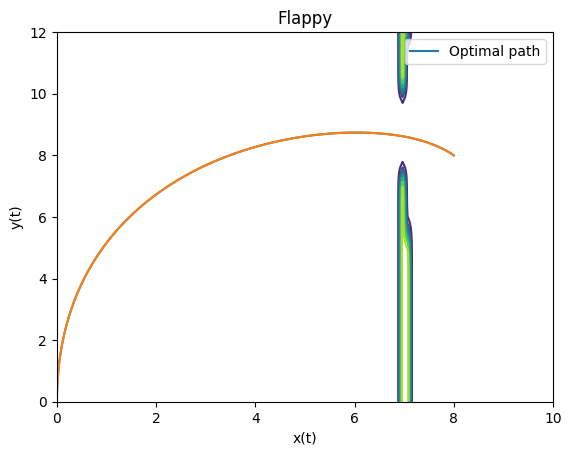

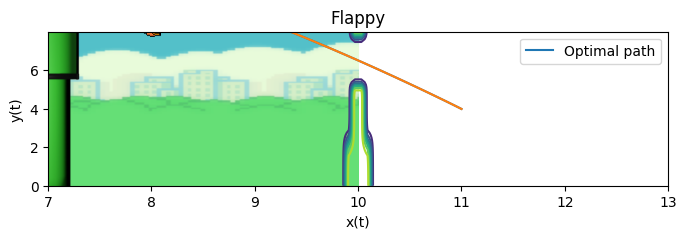

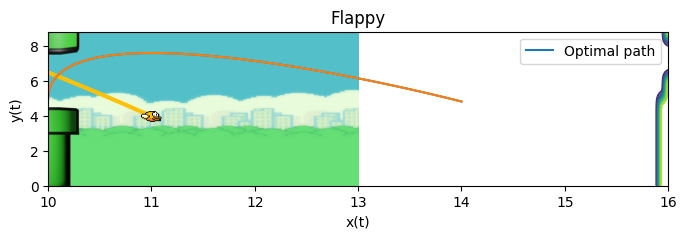

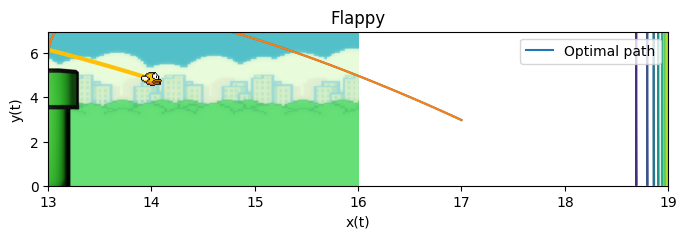

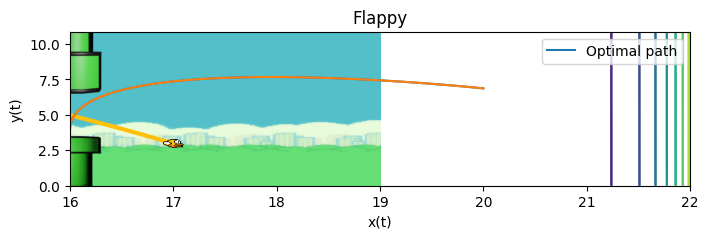

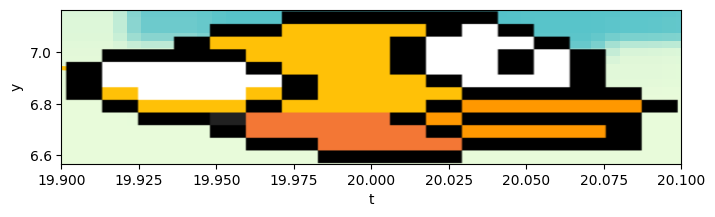

In [66]:
rys = [60, 30, 40, 20, 70]

pipe_avoid_multiple(rys)

## Print optimal u 

## Add obstacles to pipes 

/var/folders/dm/n3p7_mln4wz0tq9g5xjrsyzr0000gn/T/ipykernel_68173/3678987873.py:59: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x_, y_, obs1, colors = 'red', label = "Obstacle")


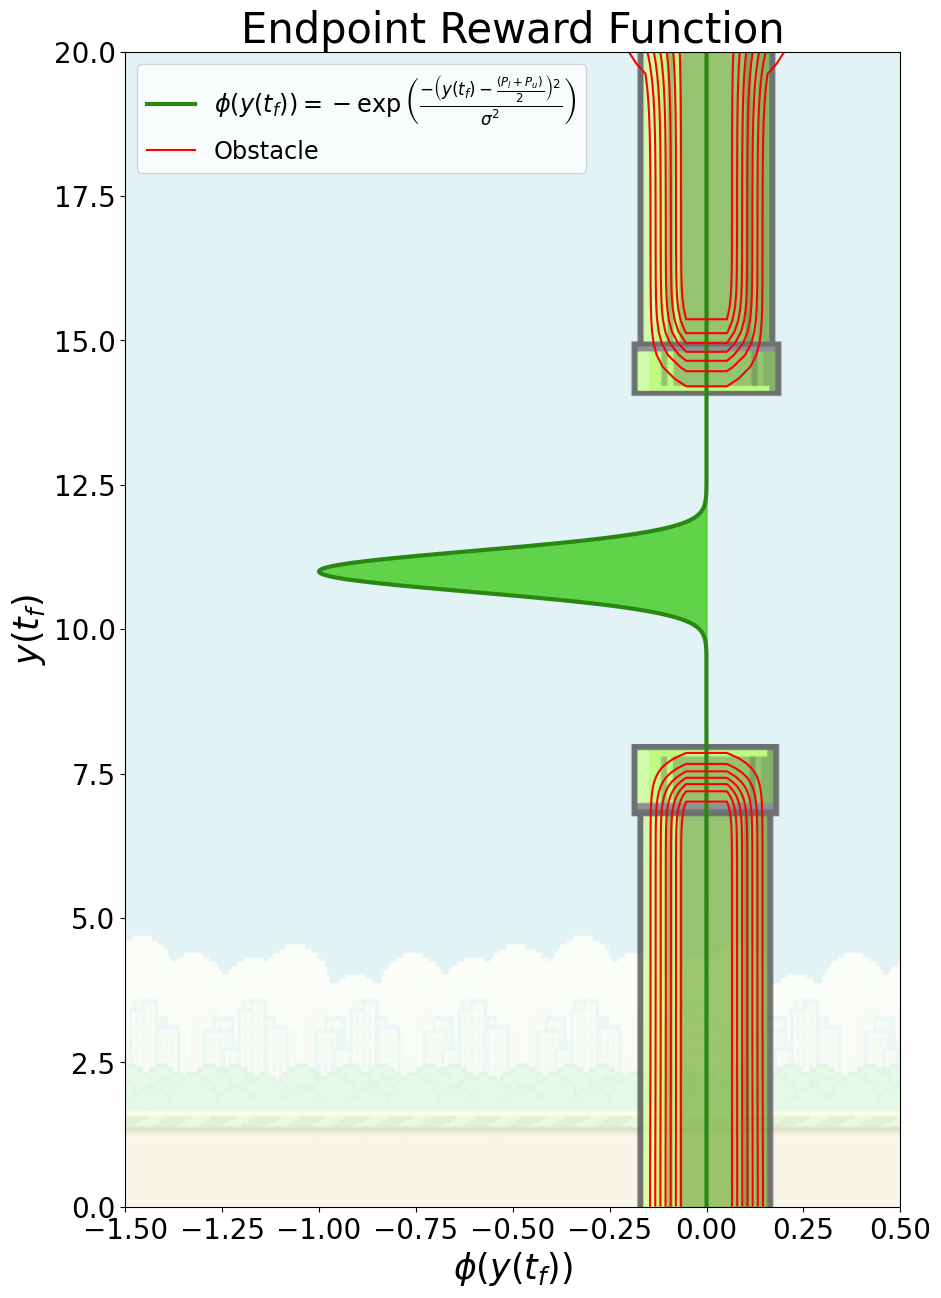

In [189]:
# setup a simple pipe for plotting
pipe_l = 8
pipe_u = 14
sigma2 = 0.5**2
ylims = (0, 20)
xlims = (-1.5, 0.5)


# define the endpoint function and get values for it to plot
def phi(y_tf):
    return -np.exp(-(y_tf - (pipe_l+pipe_u)/2)**2 / sigma2)
domain = np.linspace(ylims[0], ylims[-1], 1000)
xs = np.ones(1000)

# set various plotting parameters for color and transparency
bg_alpha = 0.2
pipe_alpha = 0.75
REWARD_COLOR = "#2b8714"
REWARD_COLOR_FILL = "#41cc1f"
plt.xlim(*xlims)
plt.ylim(*ylims)

# plot the reward function with an appropriate label
equation_latex = r"$\phi (y(t_f)) = - \exp\left(\frac{-\left(y(t_f) - \frac{(P_l+P_u)}{2}\right)^2}{\sigma^2}\right)$"
plt.plot(phi(domain), domain, REWARD_COLOR, linewidth=3, label=equation_latex)
plt.fill_betweenx(domain, phi(domain), x2=0, color=REWARD_COLOR_FILL, alpha=0.8)

# plot the background
background = mpimg.imread('images/used/background.jpg')
h, w, c = background.shape
background = background[:, :int(w // 3), :]
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=bg_alpha)

# plot the lower pipe
width = 0.2
xmin, xmax = 0-width, 0+width
ymin, ymax = ylims[0], pipe_l
img = mpimg.imread('images/used/pipe_lower_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=pipe_alpha)

#plot lower obstacle
X = np.linspace(xmin - 5, xmax + 5,100)
Y = np.linspace(0,ymax,100)
x_,y_ = np.meshgrid(X,Y)
obs1 = obstacle(x_,y_,W1=20,r=(.02,(ymax - ymin)**2),c=(0, 0))
plt.contour(x_, y_, obs1, colors = 'red')

# plot the upper pipe
xmin, xmax = 0-width, 0+width
ymin, ymax = pipe_u, ylims[1]
img = mpimg.imread('images/used/pipe_upper_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=pipe_alpha)

#plot upper obstacle 
X = np.linspace(xmin - 5, xmax + 5,100)
Y = np.linspace(0,ymax,100)
x_,y_ = np.meshgrid(X,Y)
obs1 = obstacle(x_,y_,W1=20,r=(.03,(ylims[0]-pipe_l)**2+ 62),c=(0, ylims[1] + 5.5))
plt.contour(x_, y_, obs1, colors = 'red', label = "Obstacle")
plt.plot([], [], color='red', label='Obstacle')


plt.gcf().set_size_inches(10, 15)
plt.title("Endpoint Reward Function", fontsize=30)
plt.xlabel(r"$\phi(y(t_f))$", fontsize=25)
plt.ylabel(r"$y(t_f)$", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize='xx-large')
plt.savefig("images/poster/reward_obstacle.png", dpi=600, bbox_inches="tight")
plt.show()